
## To classify severity of damage - minor, moderate or severe.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import urllib
from IPython.display import Image, display, clear_output
from collections import Counter

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import json
from sklearn.metrics import classification_report, confusion_matrix

sns.set_palette("cubehelix")
sns.set_style('whitegrid')

In [ ]:
import os
import h5py
import numpy as np
import pandas as pd

import tensorflow as tf
from keras.applications.vgg16 import VGG16
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.regularizers import l2, l1
from keras.models import Sequential, load_model,Model
from keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.layers import Activation, Dropout, Flatten, Dense
#from keras.utils.np_utils import to_categorical
from keras.utils import to_categorical

from tensorflow.keras import optimizers
from keras.callbacks import ModelCheckpoint, History

In [ ]:
def save_bottleneck_features(location):
    datagen = ImageDataGenerator(rescale=1./255)

    model = VGG16(include_top=False, weights='imagenet')

    generator = datagen.flow_from_directory(train_data_dir,
                                            target_size=(img_width, img_height),
                                            batch_size=16,
                                            class_mode=None,
                                            shuffle=False)

    bottleneck_features_train = model.predict(generator, nb_train_samples)
    np.save(location+'/bottleneck_features_train.npy', bottleneck_features_train)

    # repeat with the validation data
    generator = datagen.flow_from_directory(validation_data_dir,
                                           target_size=(img_width, img_height),
                                           batch_size=16,
                                           class_mode=None,
                                           shuffle=False)
    bottleneck_features_validation = model.predict(generator, nb_validation_samples)
    np.save(location+'/bottleneck_features_validation.npy', bottleneck_features_validation)

In [ ]:
def print_best_model_results(model_hist):
    best_epoch = np.argmax(model_hist['val_accuracy'])
    print('epoch:', best_epoch+1, \
    ', val_accuracy:', model_hist['val_accuracy'][best_epoch], \
    ', val_loss:', model_hist['val_loss'][best_epoch])

In [ ]:
def plot_metrics(hist, stop=50):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,4))

    axes = axes.flatten()

    axes[0].plot(range(stop), hist['accuracy'], label='Training')
    axes[0].plot(range(stop), hist['val_accuracy'], label='Validation')
    axes[0].set_title('Accuracy')
    axes[0].set_ylabel('Accuracy')
    axes[0].set_xlabel('Epoch')
    axes[0].legend(loc='lower right')

    axes[1].plot(range(stop), hist['loss'], label='Training')
    axes[1].plot(range(stop), hist['val_loss'], label='Validation')
    axes[1].set_title('Loss')
    axes[1].set_ylabel('Loss')
    axes[1].set_xlabel('Epoch')
    axes[1].legend(loc='upper right')

    plt.tight_layout();

    print("Best Model:")
    print_best_model_results(hist)

In [ ]:
def evaluate_categorical_model(model, directory, labels):
    datagen = ImageDataGenerator(rescale=1./255)

    generator = datagen.flow_from_directory(directory,
                                target_size=(img_height, img_width),
                                batch_size=8,
                                class_mode='categorical',
                                shuffle=False)

    predictions = model.predict_generator(generator, len(labels))
    pred_labels = np.argmax(predictions, axis=1)

    print('')
    print(classification_report(validation_labels, pred_labels))
    print('')
    cm = confusion_matrix(validation_labels, pred_labels)
    return cm

In [ ]:
def view_images(img_dir, img_list):
    for img in img_list:
        clear_output()
        display(Image(img_dir+img))
        num = input("c to continue, q to quit")
        if num == 'c':
            pass
        else:
            return 'Finished for now.'

## Defining Input Data

In [ ]:
# path to the model weights file
location = '/content/drive/MyDrive/data3a'
top_model_weights_path=location+'/top_model_weights' # will be saved into when we create our model
fine_tuned_model_path = location+'/ft_model'

# dimensions of our images
img_width, img_height = 256, 256

train_data_dir = location+'/training'
validation_data_dir = location+'/validation'

train_samples = [len(os.listdir(train_data_dir+'/'+i)) for i in sorted(os.listdir(train_data_dir))]
nb_train_samples = sum(train_samples)
validation_samples = [len(os.listdir(validation_data_dir+'/'+i)) for i in sorted(os.listdir(validation_data_dir))]
nb_validation_samples = sum(validation_samples)

nb_epoch = 50
batch_size = 16

In [ ]:
# do not rerun!
#save_bottleneck_features(location)

58889256/58889256 [==============================] - 0s 0us/step
Found 979 images belonging to 3 classes.
62/62 [==============================] - 288s 5s/step
Found 171 images belonging to 3 classes.
11/11 [==============================] - 64s 6s/step


## Model Parameter Selection

In [ ]:
def train_categorical_model1():
    train_data = np.load(location+'/bottleneck_features_train.npy')
    train_labels = np.array([0] * train_samples[0] +
                            [1] * train_samples[1] +
                            [2] * train_samples[2])
    train_labels = to_categorical(train_labels)

    validation_data = np.load(location+'/bottleneck_features_validation.npy')
    validation_labels = np.array([0] * (validation_samples[0]) +
                                 [1] * (validation_samples[1]) +
                                 [2] * (validation_samples[2]))
    validation_labels = to_categorical(validation_labels)

    model = Sequential()
    model.add(Flatten(input_shape=train_data.shape[1:]))
    model.add(Dense(3, activation = 'softmax'))

    model.compile(optimizer='rmsprop',
                  loss='categorical_crossentropy', metrics=['accuracy'])

    checkpoint = ModelCheckpoint(top_model_weights_path+"_1.hdf5", monitor='val_accuracy',
                                 verbose=2, save_best_only=True, save_weights_only=True, mode='max')

    fit = model.fit(train_data, train_labels,
              epochs=nb_epoch, batch_size=16,
              validation_data=(validation_data, validation_labels),
              callbacks=[checkpoint])

    with open(location+'/top_history_1.txt', 'w') as f:
        json.dump(fit.history, f)

    return model, fit.history

In [ ]:
d3_model1, d3_hist1 = train_categorical_model1()

Epoch 1/50
60/62 [============================>.] - ETA: 0s - loss: 2.9125 - accuracy: 0.4656
Epoch 1: val_accuracy improved from -inf to 0.46199, saving model to /content/drive/MyDrive/data3a/top_model_weights_1.hdf5
62/62 [==============================] - 1s 8ms/step - loss: 2.8935 - accuracy: 0.4658 - val_loss: 3.5491 - val_accuracy: 0.4620
Epoch 2/50
49/62 [======================>.......] - ETA: 0s - loss: 1.4256 - accuracy: 0.6352
Epoch 2: val_accuracy improved from 0.46199 to 0.61404, saving model to /content/drive/MyDrive/data3a/top_model_weights_1.hdf5
62/62 [==============================] - 0s 4ms/step - loss: 1.4252 - accuracy: 0.6251 - val_loss: 2.8234 - val_accuracy: 0.6140
Epoch 3/50
62/62 [==============================] - ETA: 0s - loss: 1.1034 - accuracy: 0.7211
Epoch 3: val_accuracy did not improve from 0.61404
62/62 [==============================] - 0s 4ms/step - loss: 1.1034 - accuracy: 0.7211 - val_loss: 3.6915 - val_accuracy: 0.4327
Epoch 4/50
50/62 [===========

Best Model:
epoch: 8 , val_accuracy: 0.6374269127845764 , val_loss: 2.1911091804504395


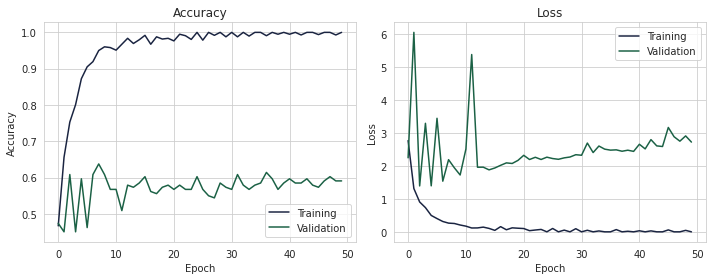

In [ ]:
plot_metrics(d3_hist1) # no regularization with 1 dense

Best Model:
epoch: 18 , val_accuracy: 0.6374269127845764 , val_loss: 1.155106782913208


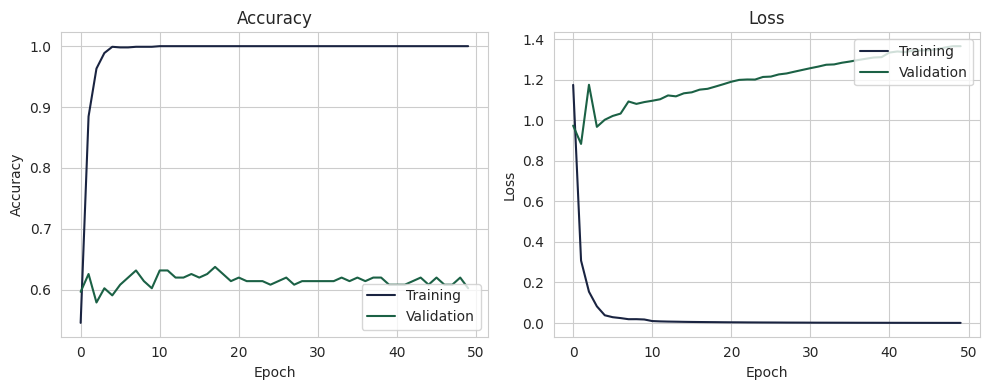

In [ ]:
plot_metrics(d3_adam_hist1) # no regularization with 1 dense

In [ ]:
def train_categorical_modelAdam():
    train_data = np.load(location+'/bottleneck_features_train.npy')
    train_labels = np.array([0] * train_samples[0] +
                            [1] * train_samples[1] +
                            [2] * train_samples[2])
    train_labels = to_categorical(train_labels)

    validation_data = np.load(location+'/bottleneck_features_validation.npy')
    validation_labels = np.array([0] * (validation_samples[0]) +
                                 [1] * (validation_samples[1]) +
                                 [2] * (validation_samples[2]))
    validation_labels = to_categorical(validation_labels)

    model = Sequential()
    model.add(Flatten(input_shape=train_data.shape[1:]))
    model.add(Dense(3, activation = 'softmax'))

    model.compile(optimizer='adam',
                  loss='categorical_crossentropy', metrics=['accuracy'])

    checkpoint = ModelCheckpoint(top_model_weights_path+"adam_1.hdf5", monitor='val_accuracy',
                                 verbose=2, save_best_only=True, save_weights_only=True, mode='max')

    fit = model.fit(train_data, train_labels,
              epochs=nb_epoch, batch_size=16,
              validation_data=(validation_data, validation_labels),
              callbacks=[checkpoint])

    with open(location+'/top_history_adam_1.txt', 'w') as f:
        json.dump(fit.history, f)

    return model, fit.history

In [ ]:
d3_adam_model1, d3_adam_hist1 = train_categorical_modelAdam()

Epoch 1/50
60/62 [============================>.] - ETA: 0s - loss: 1.1805 - accuracy: 0.5427
Epoch 1: val_accuracy improved from -inf to 0.59649, saving model to /content/drive/MyDrive/data3a/top_model_weightsadam_1.hdf5
62/62 [==============================] - 2s 12ms/step - loss: 1.1744 - accuracy: 0.5455 - val_loss: 0.9735 - val_accuracy: 0.5965
Epoch 2/50
53/62 [========================>.....] - ETA: 0s - loss: 0.2915 - accuracy: 0.8950
Epoch 2: val_accuracy improved from 0.59649 to 0.62573, saving model to /content/drive/MyDrive/data3a/top_model_weightsadam_1.hdf5
62/62 [==============================] - 0s 7ms/step - loss: 0.3081 - accuracy: 0.8846 - val_loss: 0.8834 - val_accuracy: 0.6257
Epoch 3/50
56/62 [==========================>...] - ETA: 0s - loss: 0.1536 - accuracy: 0.9654
Epoch 3: val_accuracy did not improve from 0.62573
62/62 [==============================] - 0s 7ms/step - loss: 0.1545 - accuracy: 0.9632 - val_loss: 1.1750 - val_accuracy: 0.5789
Epoch 4/50
48/62 [==

In [ ]:
def train_categorical_model2():
    train_data = np.load(location+'/bottleneck_features_train.npy')
    train_labels = np.array([0] * train_samples[0] +
                            [1] * train_samples[1] +
                            [2] * train_samples[2])
    train_labels = to_categorical(train_labels)

    validation_data = np.load(location+'/bottleneck_features_validation.npy')
    validation_labels = np.array([0] * (validation_samples[0]) +
                                 [1] * (validation_samples[1]) +
                                 [2] * (validation_samples[2]))
    validation_labels = to_categorical(validation_labels)

    model = Sequential()
    model.add(Flatten(input_shape=train_data.shape[1:]))
    model.add(Dense(256, activation = 'relu',kernel_regularizer='l2'))
    model.add(Dense(3, activation = 'softmax'))

    model.compile(optimizer='rmsprop',
                  loss='categorical_crossentropy', metrics=['accuracy'])

    checkpoint = ModelCheckpoint(top_model_weights_path+"_2.hdf5", monitor='val_accuracy',
                                 verbose=2, save_best_only=True, save_weights_only=True, mode='max')

    fit = model.fit(train_data, train_labels,
              epochs=nb_epoch, batch_size=16,
              validation_data=(validation_data, validation_labels),
              callbacks=[checkpoint])

    with open(location+'/top_history_2.txt', 'w') as f:
        json.dump(fit.history, f)

    return model, fit.history

In [ ]:
d3_model2, d3_hist2 = train_categorical_model2() # l2 regularization with rmsprop

Epoch 1/50
53/62 [========================>.....] - ETA: 0s - loss: 5.4949 - accuracy: 0.4705
Epoch 1: val_accuracy improved from -inf to 0.41520, saving model to /content/drive/MyDrive/data3a/top_model_weights_2.hdf5
62/62 [==============================] - 2s 11ms/step - loss: 4.9417 - accuracy: 0.4964 - val_loss: 1.5016 - val_accuracy: 0.4152
Epoch 2/50
55/62 [=========================>....] - ETA: 0s - loss: 1.3368 - accuracy: 0.6102
Epoch 2: val_accuracy improved from 0.41520 to 0.54386, saving model to /content/drive/MyDrive/data3a/top_model_weights_2.hdf5
62/62 [==============================] - 1s 8ms/step - loss: 1.3039 - accuracy: 0.6067 - val_loss: 1.3043 - val_accuracy: 0.5439
Epoch 3/50
54/62 [=========================>....] - ETA: 0s - loss: 1.0633 - accuracy: 0.6377
Epoch 3: val_accuracy improved from 0.54386 to 0.56725, saving model to /content/drive/MyDrive/data3a/top_model_weights_2.hdf5
62/62 [==============================] - 1s 8ms/step - loss: 1.0458 - accuracy: 0

Best Model:
epoch: 9 , val_accuracy: 0.6315789222717285 , val_loss: 1.2736810445785522


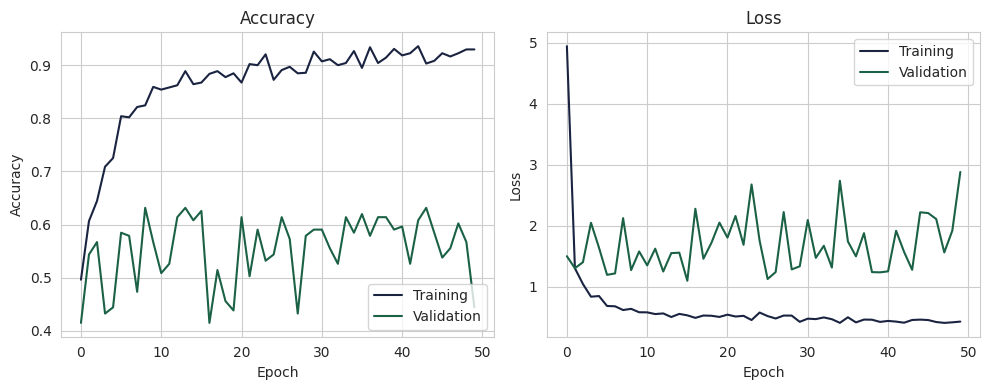

In [ ]:
plot_metrics(d3_hist2)

In [ ]:
def train_categorical_model3():
    train_data = np.load(location+'/bottleneck_features_train.npy')
    train_labels = np.array([0] * train_samples[0] +
                            [1] * train_samples[1] +
                            [2] * train_samples[2])
    train_labels = to_categorical(train_labels)

    validation_data = np.load(location+'/bottleneck_features_validation.npy')
    validation_labels = np.array([0] * (validation_samples[0]) +
                                 [1] * (validation_samples[1]) +
                                 [2] * (validation_samples[2]))
    validation_labels = to_categorical(validation_labels)

    model = Sequential()
    model.add(Flatten(input_shape=train_data.shape[1:]))
    model.add(Dense(256, activation = 'relu',kernel_regularizer='l2'))
    model.add(Dropout(0.5))
    model.add(Dense(3, activation = 'softmax'))

    model.compile(optimizer='rmsprop',
                  loss='categorical_crossentropy', metrics=['accuracy'])

    checkpoint = ModelCheckpoint(top_model_weights_path+"_3.hdf5", monitor='val_accuracy',
                                 verbose=2, save_best_only=True, save_weights_only=True, mode='max')

    fit = model.fit(train_data, train_labels,
              epochs=nb_epoch, batch_size=16,
              validation_data=(validation_data, validation_labels),
              callbacks=[checkpoint])

    with open(location+'/top_history_3.txt', 'w') as f:
        json.dump(fit.history, f)

    return model, fit.history

In [ ]:
d3_model3, d3_hist3 = train_categorical_model3() # l2 regularization and dropout

Epoch 1/50
58/62 [===========================>..] - ETA: 0s - loss: 6.1018 - accuracy: 0.4526
Epoch 1: val_accuracy improved from -inf to 0.40351, saving model to /content/drive/MyDrive/data3a/top_model_weights_3.hdf5
62/62 [==============================] - 2s 12ms/step - loss: 5.8758 - accuracy: 0.4474 - val_loss: 1.6212 - val_accuracy: 0.4035
Epoch 2/50
53/62 [========================>.....] - ETA: 0s - loss: 1.5242 - accuracy: 0.4894
Epoch 2: val_accuracy improved from 0.40351 to 0.59649, saving model to /content/drive/MyDrive/data3a/top_model_weights_3.hdf5
62/62 [==============================] - 1s 9ms/step - loss: 1.5095 - accuracy: 0.4872 - val_loss: 0.9871 - val_accuracy: 0.5965
Epoch 3/50
52/62 [========================>.....] - ETA: 0s - loss: 1.1244 - accuracy: 0.5349
Epoch 3: val_accuracy did not improve from 0.59649
62/62 [==============================] - 0s 6ms/step - loss: 1.1011 - accuracy: 0.5444 - val_loss: 0.9575 - val_accuracy: 0.5731
Epoch 4/50
54/62 [==========

Best Model:
epoch: 31 , val_accuracy: 0.6549707651138306 , val_loss: 0.9926478266716003


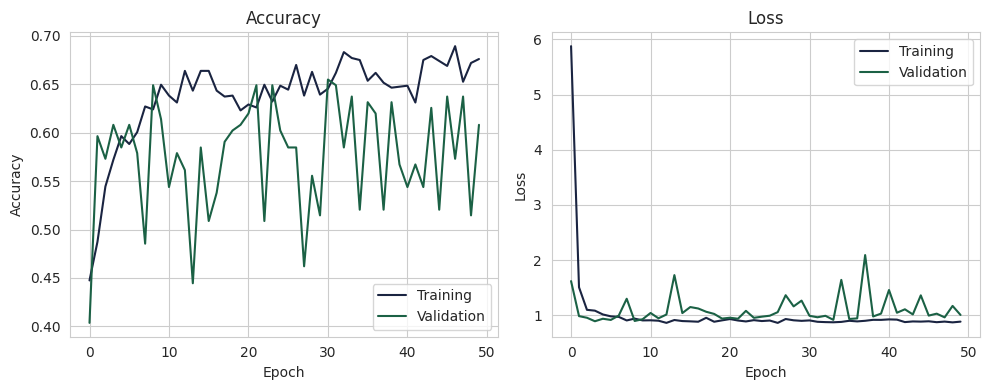

In [ ]:
plot_metrics(d3_hist3)

In [ ]:
def train_categorical_model4():
    train_data = np.load(location+'/bottleneck_features_train.npy')
    train_labels = np.array([0] * train_samples[0] +
                            [1] * train_samples[1] +
                            [2] * train_samples[2])
    train_labels = to_categorical(train_labels)

    validation_data = np.load(location+'/bottleneck_features_validation.npy')
    validation_labels = np.array([0] * (validation_samples[0]) +
                                 [1] * (validation_samples[1]) +
                                 [2] * (validation_samples[2]))
    validation_labels = to_categorical(validation_labels)

    model = Sequential()
    model.add(Flatten(input_shape=train_data.shape[1:]))
    model.add(Dense(256, activation = 'relu',kernel_regularizer='l2'))
    model.add(Dropout(0.75))
    model.add(Dense(3, activation = 'softmax'))

    model.compile(optimizer='rmsprop',
                  loss='categorical_crossentropy', metrics=['accuracy'])

    checkpoint = ModelCheckpoint(top_model_weights_path+"_4.hdf5", monitor='val_accuracy',
                                 verbose=2, save_best_only=True, save_weights_only=True, mode='max')

    fit = model.fit(train_data, train_labels,
              epochs=nb_epoch, batch_size=16,
              validation_data=(validation_data, validation_labels),
              callbacks=[checkpoint])

    with open(location+'/top_history_4.txt', 'w') as f:
        json.dump(fit.history, f)

    return model, fit.history

In [ ]:
d3_model4, d3_hist4 = train_categorical_model4() # l2 regularization and aggresive dropout

Epoch 1/50
52/62 [========================>.....] - ETA: 0s - loss: 5.4470 - accuracy: 0.4219
Epoch 1: val_accuracy improved from -inf to 0.44444, saving model to /content/drive/MyDrive/data3a/top_model_weights_4.hdf5
62/62 [==============================] - 2s 11ms/step - loss: 4.8914 - accuracy: 0.4290 - val_loss: 1.5424 - val_accuracy: 0.4444
Epoch 2/50
54/62 [=========================>....] - ETA: 0s - loss: 1.5502 - accuracy: 0.4479
Epoch 2: val_accuracy did not improve from 0.44444
62/62 [==============================] - 0s 6ms/step - loss: 1.5239 - accuracy: 0.4494 - val_loss: 1.4503 - val_accuracy: 0.2807
Epoch 3/50
54/62 [=========================>....] - ETA: 0s - loss: 1.2352 - accuracy: 0.4838
Epoch 3: val_accuracy did not improve from 0.44444
62/62 [==============================] - 0s 6ms/step - loss: 1.2716 - accuracy: 0.4831 - val_loss: 1.1476 - val_accuracy: 0.3509
Epoch 4/50
53/62 [========================>.....] - ETA: 0s - loss: 1.1591 - accuracy: 0.4823
Epoch 4: v

Best Model:
epoch: 15 , val_accuracy: 0.6432748436927795 , val_loss: 0.9066848158836365


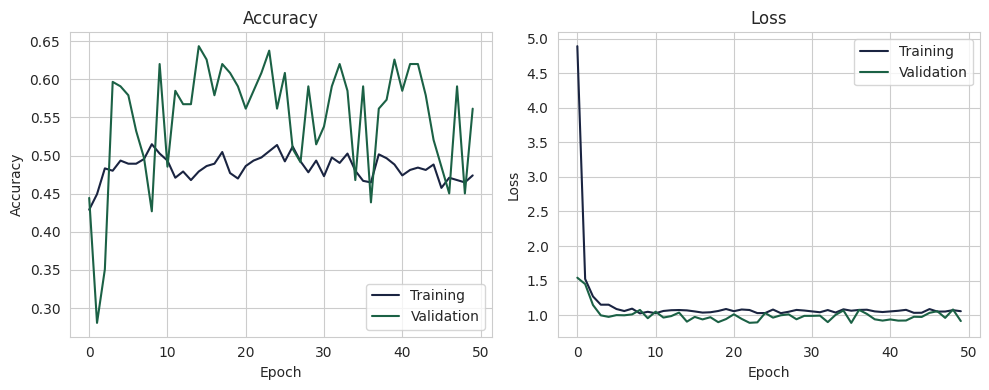

In [ ]:
plot_metrics(d3_hist4)

In [ ]:
def train_categorical_model5():
    train_data = np.load(location+'/bottleneck_features_train.npy')
    train_labels = np.array([0] * train_samples[0] +
                            [1] * train_samples[1] +
                            [2] * train_samples[2])
    train_labels = to_categorical(train_labels)

    validation_data = np.load(location+'/bottleneck_features_validation.npy')
    validation_labels = np.array([0] * (validation_samples[0]) +
                                 [1] * (validation_samples[1]) +
                                 [2] * (validation_samples[2]))
    validation_labels = to_categorical(validation_labels)

    model = Sequential()
    model.add(Flatten(input_shape=train_data.shape[1:]))
    model.add(Dense(256, activation = 'relu',kernel_regularizer='l2'))
    model.add(Dropout(0.5))
    model.add(Dense(3, activation = 'softmax'))

    model.compile(optimizers.SGD(lr=0.0001, momentum=0.9),
              loss='categorical_crossentropy', metrics=['accuracy'])


    checkpoint = ModelCheckpoint(top_model_weights_path+"_5.hdf5", monitor='val_accuracy',
                                 verbose=2, save_best_only=True, save_weights_only=True, mode='max')

    fit = model.fit(train_data, train_labels,
              epochs=nb_epoch, batch_size=16,
              validation_data=(validation_data, validation_labels),
              callbacks=[checkpoint])

    with open(location+'/top_history_5.txt', 'w') as f:
        json.dump(fit.history, f)

    return model, fit.history

In [ ]:
d3_model5, d3_hist5 = train_categorical_model5() # dense and dropout layers with l2 regularization and sgd

Epoch 1/50
60/62 [============================>.] - ETA: 0s - loss: 8.6281 - accuracy: 0.3750
Epoch 1: val_accuracy improved from -inf to 0.39766, saving model to /content/drive/MyDrive/data3a/top_model_weights_5.hdf5
62/62 [==============================] - 1s 11ms/step - loss: 8.5875 - accuracy: 0.3779 - val_loss: 6.5202 - val_accuracy: 0.3977
Epoch 2/50
60/62 [============================>.] - ETA: 0s - loss: 5.9369 - accuracy: 0.3938
Epoch 2: val_accuracy did not improve from 0.39766
62/62 [==============================] - 0s 6ms/step - loss: 5.9252 - accuracy: 0.3943 - val_loss: 5.3258 - val_accuracy: 0.3977
Epoch 3/50
55/62 [=========================>....] - ETA: 0s - loss: 4.8972 - accuracy: 0.4045
Epoch 3: val_accuracy did not improve from 0.39766
62/62 [==============================] - 0s 6ms/step - loss: 4.8544 - accuracy: 0.3943 - val_loss: 4.3853 - val_accuracy: 0.3977
Epoch 4/50
55/62 [=========================>....] - ETA: 0s - loss: 4.0511 - accuracy: 0.3898
Epoch 4: v

Best Model:
epoch: 1 , val_accuracy: 0.3976608216762543 , val_loss: 6.520217418670654


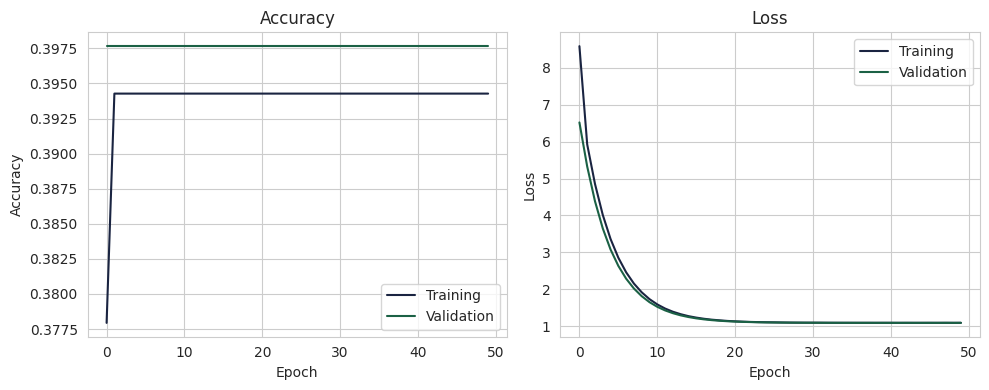

In [ ]:
plot_metrics(d3_hist5)

In [ ]:
def train_categorical_model6():
    train_data = np.load(location+'/bottleneck_features_train.npy')
    train_labels = np.array([0] * train_samples[0] +
                            [1] * train_samples[1] +
                            [2] * train_samples[2])
    train_labels = to_categorical(train_labels)

    validation_data = np.load(location+'/bottleneck_features_validation.npy')
    validation_labels = np.array([0] * (validation_samples[0]) +
                                 [1] * (validation_samples[1]) +
                                 [2] * (validation_samples[2]))
    validation_labels = to_categorical(validation_labels)

    model = Sequential()
    model.add(Flatten(input_shape=train_data.shape[1:]))
    model.add(Dense(256, activation = 'relu',kernel_regularizer='l2'))
    model.add(Dropout(0.5))
    model.add(Dense(128, activation = 'relu',kernel_regularizer='l2'))
    model.add(Dropout(0.5))
    model.add(Dense(3, activation = 'softmax'))

    model.compile(optimizers.SGD(lr=0.0001, momentum=0.9),
              loss='categorical_crossentropy', metrics=['accuracy'])


    checkpoint = ModelCheckpoint(top_model_weights_path+"_6.hdf5", monitor='val_accuracy',
                                 verbose=2, save_best_only=True, save_weights_only=True, mode='max')

    fit = model.fit(train_data, train_labels,
              epochs=nb_epoch, batch_size=16,
              validation_data=(validation_data, validation_labels),
              callbacks=[checkpoint])

    with open(location+'/top_history_6.txt', 'w') as f:
        json.dump(fit.history, f)

    return model, fit.history

In [ ]:
d3_model6, d3_hist6 = train_categorical_model6() # double dense and dropout layers with regularization

Epoch 1/50
60/62 [============================>.] - ETA: 0s - loss: 10.7341 - accuracy: 0.3583
Epoch 1: val_accuracy improved from -inf to 0.39766, saving model to /content/drive/MyDrive/data3a/top_model_weights_6.hdf5
62/62 [==============================] - 2s 12ms/step - loss: 10.6941 - accuracy: 0.3555 - val_loss: 8.5737 - val_accuracy: 0.3977
Epoch 2/50
58/62 [===========================>..] - ETA: 0s - loss: 7.7875 - accuracy: 0.3944
Epoch 2: val_accuracy did not improve from 0.39766
62/62 [==============================] - 0s 7ms/step - loss: 7.7458 - accuracy: 0.3953 - val_loss: 6.9194 - val_accuracy: 0.3977
Epoch 3/50
59/62 [===========================>..] - ETA: 0s - loss: 6.2878 - accuracy: 0.3951
Epoch 3: val_accuracy did not improve from 0.39766
62/62 [==============================] - 0s 7ms/step - loss: 6.2649 - accuracy: 0.3963 - val_loss: 5.6215 - val_accuracy: 0.3977
Epoch 4/50
61/62 [============================>.] - ETA: 0s - loss: 5.1130 - accuracy: 0.3904
Epoch 4:

Best Model:
epoch: 1 , val_accuracy: 0.3976608216762543 , val_loss: 8.573700904846191


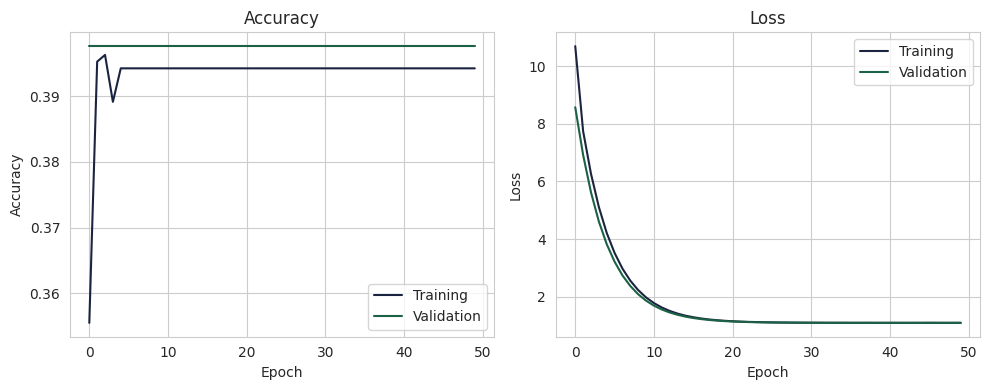

In [ ]:
plot_metrics(d3_hist6)

## Finetuning Model

In [ ]:
def finetune_categorical_model1():
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(256,256,3))

    top_model = Sequential()
    top_model.add(Flatten(input_shape=base_model.output_shape[1:]))
    top_model.add(Dense(256, activation='relu',kernel_regularizer='l2'))
    top_model.add(Dropout(0.5))
    top_model.add(Dense(3, activation='softmax'))

    top_model.load_weights(top_model_weights_path+"_3.hdf5")

    model = Model(inputs=base_model.input, outputs=top_model(base_model.output))

    for layer in model.layers[:15]:
        layer.trainable=False

    model.compile(optimizer='rmsprop',
                  loss='categorical_crossentropy', metrics=['accuracy'])

    # prepare data augmentation configuration
    train_datagen = ImageDataGenerator(rescale=1./255,
                                       rotation_range=40,
                                       width_shift_range=0.2,
                                       height_shift_range=0.2,
                                       shear_range=0.2,
                                       zoom_range=0.2,
                                       horizontal_flip=True,
                                       fill_mode='nearest')

    test_datagen = ImageDataGenerator(rescale=1./255)

    train_generator= train_datagen.flow_from_directory(train_data_dir,
                                                     target_size=(img_height, img_width),
                                                     batch_size=8,
                                                     class_mode='categorical')

    validation_generator = test_datagen.flow_from_directory(validation_data_dir,
                                                           target_size=(img_height, img_width),
                                                           batch_size=8,
                                                           class_mode='categorical')


    checkpoint = ModelCheckpoint(fine_tuned_model_path+"_1.hdf5", monitor='val_accuracy',
                                 verbose=2, save_best_only=True,
                                 save_weights_only=False, mode='max')

    # fine-tune the model
    fit = model.fit(train_generator,
                              steps_per_epoch=nb_train_samples//batch_size,
                              epochs=nb_epoch,
                              validation_data=validation_generator,
                              validation_steps = nb_validation_samples//batch_size,
                              verbose=1,
                              callbacks=[checkpoint])

    with open(location+'/ft_history_1.txt', 'w') as f:
        json.dump(fit.history, f)

    return model, fit.history

### Run 1 - With Regularization

In [ ]:
ft_d3_model1, ft_d3_hist1 = finetune_categorical_model1()

Found 979 images belonging to 3 classes.
Found 171 images belonging to 3 classes.
Epoch 1/50
61/61 [==============================] - ETA: 0s - loss: 1.4937 - accuracy: 0.4990
Epoch 1: val_accuracy improved from -inf to 0.63750, saving model to /content/drive/MyDrive/data3a/ft_model_1.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


61/61 [==============================] - 17s 213ms/step - loss: 1.4937 - accuracy: 0.4990 - val_loss: 1.0390 - val_accuracy: 0.6375
Epoch 2/50
61/61 [==============================] - ETA: 0s - loss: 1.5529 - accuracy: 0.4939
Epoch 2: val_accuracy improved from 0.63750 to 0.71250, saving model to /content/drive/MyDrive/data3a/ft_model_1.hdf5
61/61 [==============================] - 16s 262ms/step - loss: 1.5529 - accuracy: 0.4939 - val_loss: 0.9526 - val_accuracy: 0.7125
Epoch 3/50
61/61 [==============================] - ETA: 0s - loss: 1.6364 - accuracy: 0.5114
Epoch 3: val_accuracy did not improve from 0.71250
61/61 [==============================] - 15s 243ms/step - loss: 1.6364 - accuracy: 0.5114 - val_loss: 1.0656 - val_accuracy: 0.6125
Epoch 4/50
61/61 [==============================] - ETA: 0s - loss: 1.5093 - accuracy: 0.5041
Epoch 4: val_accuracy did not improve from 0.71250
61/61 [==============================] - 13s 208ms/step - loss: 1.5093 - accuracy: 0.5041 - val_loss: 

Best Model:
epoch: 2 , val_accuracy: 0.7124999761581421 , val_loss: 0.9525966644287109


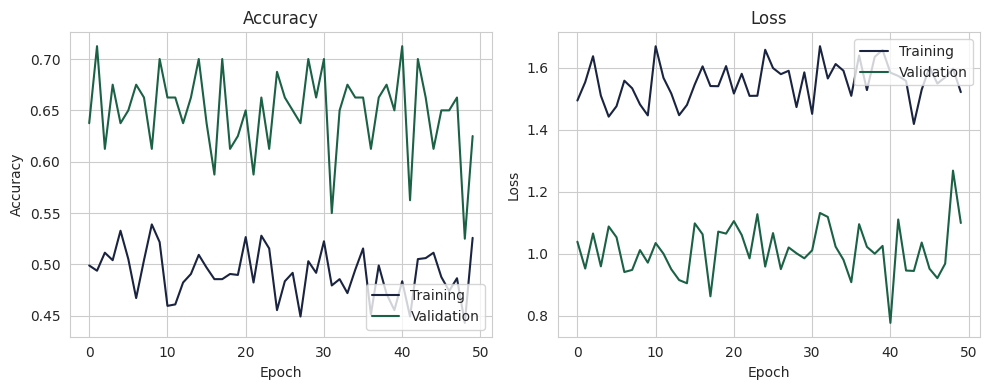

In [ ]:
plot_metrics(ft_d3_hist1)

### Run 2 - Without Regularization

In [ ]:
def finetune_categorical_model2():
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(256,256,3))

    top_model = Sequential()
    top_model.add(Flatten(input_shape=base_model.output_shape[1:]))
    top_model.add(Dense(256, activation='relu'))
    top_model.add(Dropout(0.5))
    top_model.add(Dense(3, activation='softmax'))

    top_model.load_weights(top_model_weights_path+"_3.hdf5")

    model = Model(inputs=base_model.input, outputs=top_model(base_model.output))

    for layer in model.layers[:15]:
        layer.trainable=False

    model.compile(optimizer='rmsprop',
                  loss='categorical_crossentropy', metrics=['accuracy'])

    # prepare data augmentation configuration
    train_datagen = ImageDataGenerator(rescale=1./255,
                                       rotation_range=40,
                                       width_shift_range=0.2,
                                       height_shift_range=0.2,
                                       shear_range=0.2,
                                       zoom_range=0.2,
                                       horizontal_flip=True,
                                       fill_mode='nearest')

    test_datagen = ImageDataGenerator(rescale=1./255)

    train_generator= train_datagen.flow_from_directory(train_data_dir,
                                                     target_size=(img_height, img_width),
                                                     batch_size=8,
                                                     class_mode='categorical')

    validation_generator = test_datagen.flow_from_directory(validation_data_dir,
                                                           target_size=(img_height, img_width),
                                                           batch_size=8,
                                                           class_mode='categorical')


    checkpoint = ModelCheckpoint(fine_tuned_model_path+"_2.hdf5", monitor='val_accuracy',
                                 verbose=2, save_best_only=True,
                                 save_weights_only=False, mode='max')

    # fine-tune the model
    fit = model.fit(train_generator,
                              steps_per_epoch=nb_train_samples//batch_size,
                              epochs=nb_epoch,
                              validation_data=validation_generator,
                              validation_steps = nb_validation_samples//batch_size,
                              verbose=1,
                              callbacks=[checkpoint])

    with open(location+'/ft_history_2.txt', 'w') as f:
        json.dump(fit.history, f)

    return model, fit.history

In [ ]:
ft_d3_model2, ft_d3_hist2 = finetune_categorical_model2()

Found 979 images belonging to 3 classes.
Found 171 images belonging to 3 classes.
Epoch 1/50
61/61 [==============================] - ETA: 0s - loss: 1.2862 - accuracy: 0.5020
Epoch 1: val_accuracy improved from -inf to 0.57500, saving model to /content/drive/MyDrive/data3a/ft_model_2.hdf5
61/61 [==============================] - 14s 210ms/step - loss: 1.2862 - accuracy: 0.5020 - val_loss: 0.9830 - val_accuracy: 0.5750
Epoch 2/50
61/61 [==============================] - ETA: 0s - loss: 1.3012 - accuracy: 0.5217
Epoch 2: val_accuracy improved from 0.57500 to 0.68750, saving model to /content/drive/MyDrive/data3a/ft_model_2.hdf5
61/61 [==============================] - 15s 249ms/step - loss: 1.3012 - accuracy: 0.5217 - val_loss: 0.8453 - val_accuracy: 0.6875
Epoch 3/50
61/61 [==============================] - ETA: 0s - loss: 1.3742 - accuracy: 0.4857
Epoch 3: val_accuracy did not improve from 0.68750
61/61 [==============================] - 13s 221ms/step - loss: 1.3742 - accuracy: 0.485

Best Model:
epoch: 42 , val_accuracy: 0.737500011920929 , val_loss: 0.6615745425224304


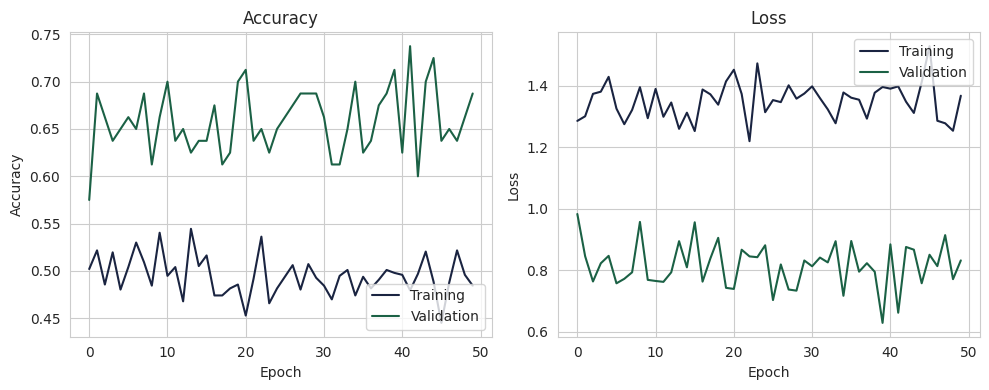

In [ ]:
plot_metrics(ft_d3_hist2)

## Model Evaluation

In [ ]:
ft_d3_model1 = load_model(location+'/ft_model_1.hdf5') # with regularization, first run

In [ ]:
validation_labels = np.array([0] * validation_samples[0] +
                             [1] * validation_samples[1] +
                             [2] * validation_samples[2])

In [ ]:
evaluate_categorical_model(ft_d3_model1, validation_data_dir, validation_labels)

Found 171 images belonging to 3 classes.


<ipython-input-8-00b1d1a1701c>:10: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predictions = model.predict_generator(generator, len(labels))



              precision    recall  f1-score   support

           0       0.78      0.60      0.68        48
           1       0.49      0.71      0.58        55
           2       0.81      0.65      0.72        68

    accuracy                           0.65       171
   macro avg       0.70      0.65      0.66       171
weighted avg       0.70      0.65      0.66       171




array([[29, 18,  1],
       [ 7, 39,  9],
       [ 1, 23, 44]])

In [ ]:
ft_d3_model2 = load_model(location+'/ft_model_2.hdf5') # without regularization, first run

In [ ]:
evaluate_categorical_model(ft_d3_model2, validation_data_dir, validation_labels)

Found 171 images belonging to 3 classes.


<ipython-input-8-00b1d1a1701c>:10: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predictions = model.predict_generator(generator, len(labels))



              precision    recall  f1-score   support

           0       0.78      0.60      0.68        48
           1       0.49      0.71      0.58        55
           2       0.81      0.65      0.72        68

    accuracy                           0.65       171
   macro avg       0.70      0.65      0.66       171
weighted avg       0.70      0.65      0.66       171




array([[29, 18,  1],
       [ 7, 39,  9],
       [ 1, 23, 44]])

Found 171 images belonging to 3 classes.

             precision    recall  f1-score   support

          0       0.79      0.71      0.75        48
          1       0.53      0.65      0.59        55
          2       0.80      0.71      0.75        68

avg / total       0.71      0.69      0.70       171




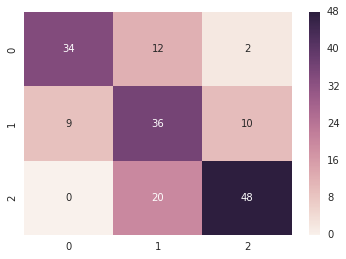

In [ ]:
#evaluate_categorical_model(ft_d3_model3, validation_data_dir, validation_labels)

## Load Model Point

In [ ]:
def plot_metrics(hist, stop=50):
    fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(4,6))

    axes = axes.flatten()

    axes[0].plot(range(stop), hist['acc'], label='Training', color='#FF533D')
    axes[0].plot(range(stop), hist['val_acc'], label='Validation', color='#03507E')
    axes[0].set_title('Accuracy')
    axes[0].set_ylabel('Accuracy')

    axes[0].set_xlabel('Epoch')
    axes[0].legend(loc='lower right')

    axes[1].plot(range(stop), hist['loss'], label='Training', color='#FF533D')
    axes[1].plot(range(stop), hist['val_loss'], label='Validation', color='#03507E')
    axes[1].set_title('Loss')
    axes[1].set_ylabel('Loss')
    axes[1].set_xlabel('Epoch')
    axes[1].legend(loc='upper right')

    plt.tight_layout();

    print("Best Model:")
    print_best_model_results(hist)

In [ ]:
def evaluate_categorical_model(model, directory, labels):
    datagen = ImageDataGenerator(rescale=1./255)

    generator = datagen.flow_from_directory(directory,
                                target_size=(img_height, img_width),
                                batch_size=8,
                                class_mode='categorical',
                                shuffle=False)

    predictions = model.predict_generator(generator, len(labels))
    pred_labels = np.argmax(predictions, axis=1)

    print('')
    print(classification_report(validation_labels, pred_labels))
    print('')
    cm = confusion_matrix(validation_labels, pred_labels)
    return cm

In [ ]:
# WINNER
ft_model = load_model(location+'/ft_model_2.hdf5')  # without regularization, second run

In [ ]:
from keras.models import load_model

# Assuming 'ft_model' is already defined and trained
ft_model.save('Severity_Check.h5')  # Save the model to a HDF5 file


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
with open(location+'/ft_history_2.txt') as f:
    ft_history = json.load(f)

In [ ]:
validation_labels = np.array([0] * validation_samples[0] +
                             [1] * validation_samples[1] +
                             [2] * validation_samples[2])

In [ ]:
cm = evaluate_categorical_model(ft_model, validation_data_dir, validation_labels)

Found 171 images belonging to 3 classes.


<ipython-input-46-9922010c8f2b>:10: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predictions = model.predict_generator(generator, len(labels))



              precision    recall  f1-score   support

           0       0.78      0.60      0.68        48
           1       0.49      0.71      0.58        55
           2       0.81      0.65      0.72        68

    accuracy                           0.65       171
   macro avg       0.70      0.65      0.66       171
weighted avg       0.70      0.65      0.66       171




In [ ]:
with open(location+'/top_history_3.txt') as f:
    top_history = json.load(f)

def plot_acc_metrics(hist1, hist2, stop=50):
    fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(4.25,7))

    axes = axes.flatten()

    axes[0].plot(range(stop), hist1['accuracy'], label='Training', color='#FF533D')
    axes[0].plot(range(stop), hist1['val_accuracy'], label='Validation', color='#03507E')
    axes[0].set_title('Training')
    axes[0].set_ylabel('Accuracy')
    axes[0].set_xlabel('Epoch')
    axes[0].legend(loc='lower right')

    axes[1].plot(range(stop), hist2['accuracy'], label='Training', color='#FF533D')
    axes[1].plot(range(stop), hist2['val_accuracy'], label='Validation', color='#03507E')
    axes[1].set_title('Fine-tuning')
    axes[1].set_ylabel('Accuracy')
    axes[1].set_xlabel('Epoch')
    axes[1].legend(loc='lower right')

    plt.tight_layout();

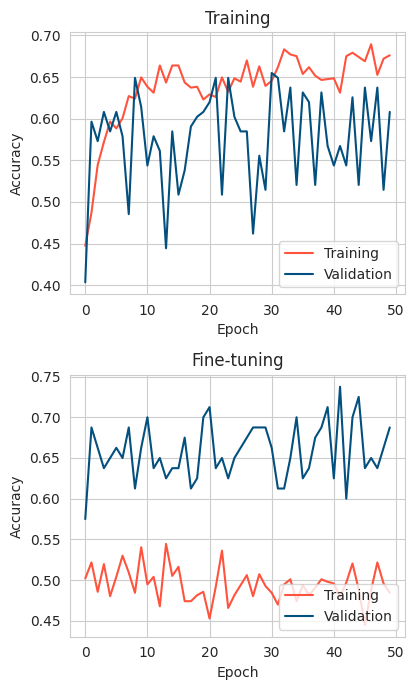

In [ ]:
plot_acc_metrics(top_history, ft_history)

In [ ]:
heatmap_labels = ['Minor', 'Moderate', 'Severe']

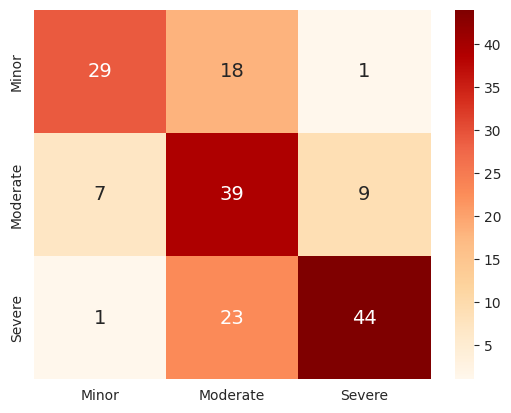

In [ ]:
sns.heatmap(cm, annot=True, annot_kws={"size": 14},
            fmt='g', cmap='OrRd', xticklabels=heatmap_labels, yticklabels=heatmap_labels);

## Making Live Predictions

In [ ]:
from urllib.request import urlretrieve
def severity_estimator(image_path, model,option=1):
    print("Determining severity of damage...")
    if(option==1):
      urlretrieve(image_path, 'save.jpg') # or other way to upload image
      img = load_img('save.jpg', target_size=(256, 256)) # this is a PIL image
    else:
      img = load_img(image_path,target_size=(256, 256))
    x = img_to_array(img) # this is a Numpy array with shape (3, 256, 256)
    x = x.reshape((1,) + x.shape)/255 # this is a Numpy array with shape (1, 3, 256, 256)
    pred = model.predict(x)
    print(pred)
    pred_label = np.argmax(pred, axis=1)
    d = {0: 'Minor', 1: 'Moderate', 2: 'Severe'}
    for key in d.keys():
        if pred_label[0] == key:
            print("Assessment: {} damage to vehicle".format(d[key]))
    print("Severity assessment complete.")

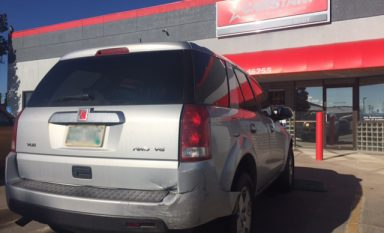

In [ ]:
Image('https://www.nerdwallet.com/blog/wp-content/uploads/2015/12/exterior-car-damage-384x233.jpg')

In [ ]:
severity_estimator('https://www.nerdwallet.com/blog/wp-content/uploads/2015/12/exterior-car-damage-384x233.jpg', ft_model)

Determining severity of damage...
1/1 [==============================] - 1s 1s/step
[[0.83139455 0.16455013 0.00405535]]
Assessment: Minor damage to vehicle
Severity assessment complete.


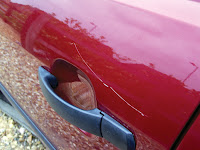

In [ ]:
Image('http://1.bp.blogspot.com/-ToQS-qIxYbo/UDNuV5OcVQI/AAAAAAAABdo/tjeQywWiOo0/s200/Key+scratch.jpg')

In [ ]:
severity_estimator('http://1.bp.blogspot.com/-ToQS-qIxYbo/UDNuV5OcVQI/AAAAAAAABdo/tjeQywWiOo0/s200/Key+scratch.jpg', ft_model)

Determining severity of damage...
1/1 [==============================] - 0s 19ms/step
[[0.45776978 0.522871   0.01935917]]
Assessment: Moderate damage to vehicle
Severity assessment complete.


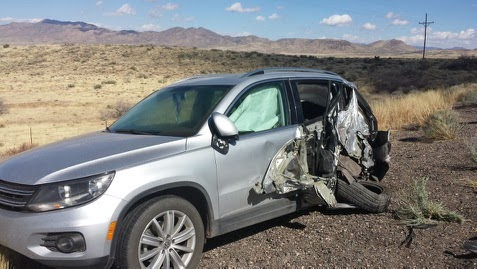

In [ ]:
Image('http://1.bp.blogspot.com/-hzoFer11Gcw/Uw_b0Z8HGAI/AAAAAAAAA4M/XjV-NrRl0iM/s1600/20140227_140935.jpg')

In [ ]:
severity_estimator('http://1.bp.blogspot.com/-hzoFer11Gcw/Uw_b0Z8HGAI/AAAAAAAAA4M/XjV-NrRl0iM/s1600/20140227_140935.jpg', ft_model)

Determining severity of damage...
1/1 [==============================] - 0s 18ms/step
[[0.01247585 0.39748925 0.5900349 ]]
Assessment: Severe damage to vehicle
Severity assessment complete.


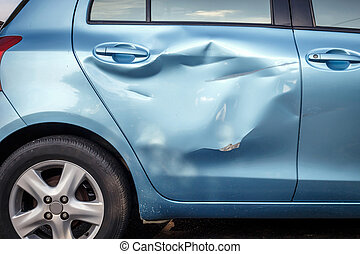

In [ ]:
Image('http://cdn.xl.thumbs.canstockphoto.com/canstock23892567.jpg')

In [ ]:
severity_estimator('http://cdn.xl.thumbs.canstockphoto.com/canstock23892567.jpg', ft_model)

Determining severity of damage...
1/1 [==============================] - 0s 21ms/step
[[0.38123968 0.5772362  0.04152415]]
Assessment: Moderate damage to vehicle
Severity assessment complete.


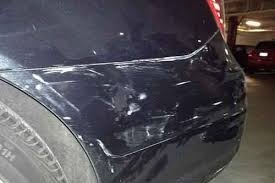

In [ ]:
Image(location+'/validation/01-minor/0001.JPEG')

In [ ]:
severity_estimator(location+'/validation/01-minor/0001.JPEG', ft_model,option=0)

Determining severity of damage...
1/1 [==============================] - 0s 19ms/step
[[0.5954835  0.39199355 0.01252301]]
Assessment: Minor damage to vehicle
Severity assessment complete.


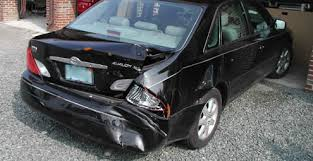

In [ ]:
Image(location+'/validation/02-moderate/0002.JPEG')

In [ ]:
severity_estimator(location+'/validation/02-moderate/0003.JPEG', ft_model,option=0)

Determining severity of damage...
1/1 [==============================] - 0s 19ms/step
[[0.12430939 0.75917256 0.11651807]]
Assessment: Moderate damage to vehicle
Severity assessment complete.


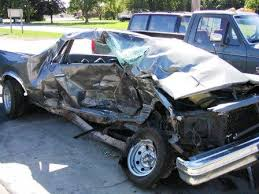

In [ ]:
Image(location+'/validation/03-severe/0002.JPEG')

In [ ]:
severity_estimator(location+'/validation/03-severe/0002.JPEG', ft_model,option=0)

Determining severity of damage...
1/1 [==============================] - 0s 18ms/step
[[1.4675886e-05 1.1055736e-02 9.8892957e-01]]
Assessment: Severe damage to vehicle
Severity assessment complete.
